# Settings

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from scipy import stats
from numpy.random import randn
import copy

# Cross Validation for Linear Regression

## linear CV vs fast CV

In [0]:
n = 1000; p = 5
X = np.insert(randn(n, p), 0, 1, axis=1)
beta = randn(p+1).reshape(-1, 1)
y = X@beta + 0.2 * randn(n).reshape(-1, 1)
y = y[:, 0]

In [0]:
# normal cross validation
def cv_linear(X, y, K):
  n = len(y); m = int(n/K)
  S = 0
  for j in range(K):
    test = list(range(j * m, (j+1) * m))
    train = list(set(range(n)) - set(test))
    beta = np.linalg.inv(X[train, ].T@X[train, ])@X[train, ].T@y[train]
    e = y[test] - X[test, ]@beta
    S += np.linalg.norm(e)**2
  return S / n

In [0]:
# use formulation
def cv_fast(X, y, k):
  n = len(y)
  m = n/k
  H = X@np.linalg.inv(X.T@X)@X.T
  I = np.diag(np.repeat(1, n))
  e = (I - H)@y
  I = np.diag(np.repeat(1, m))
  S = 0
  for j in range(k):
    test = np.arange(j * m, (j+1) * m, 1, dtype=int)
    S += (np.linalg.inv(I - H[test, test])@e[test]).T@np.linalg.inv(I - H[test, test])@e[test]
  return S / n

In [0]:
import time

In [0]:
U_l = []; V_l = []; S_l = []
U_f = []; V_f = []; S_f = []
for k in range(2, n+1, 1):
  if n%k==0:
    t1 = time.time()
    S = cv_linear(X, y, k)
    t2 = time.time()
    U_l.append(k); V_l.append(t2 - t1); S_l.append(S)

    t1 = time.time()
    S = cv_fast(X, y, k)
    t2 = time.time()
    U_f.append(k); V_f.append(t2 - t1); S_f.append(S)

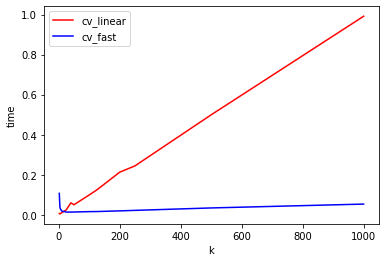

In [7]:
plt.xlabel('k')
plt.ylabel('time')
plt.plot(U_l, V_l, label='cv_linear', color='red')
plt.plot(U_f, V_f, label='cv_fast', color='blue')
plt.legend()
plt.show()

No handles with labels found to put in legend.


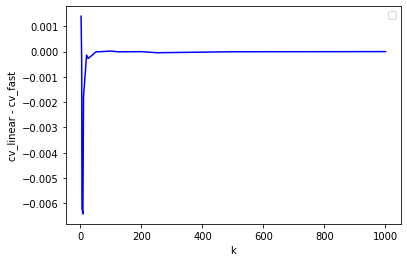

In [8]:
S_diff = [s_l - s_f for s_l, s_f in zip(S_l, S_f)]
plt.xlabel('k')
plt.ylabel('cv_linear - cv_fast')
plt.plot(U_f, S_diff, color='blue')
plt.legend()
plt.show()

`cv_linear` and `cv_fast` are same output, but **cv_fast is much faster**.

## k-loss

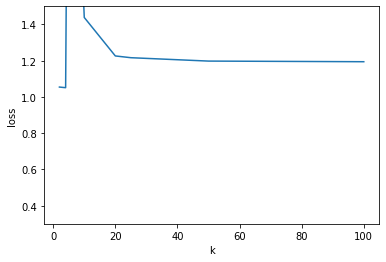

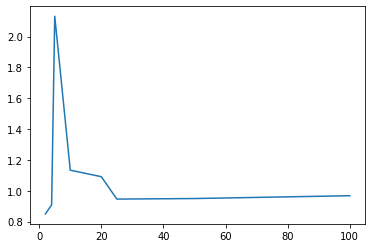

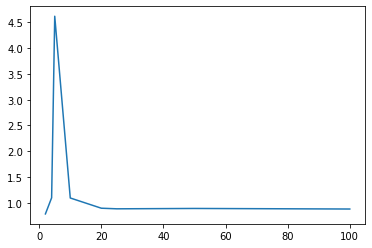

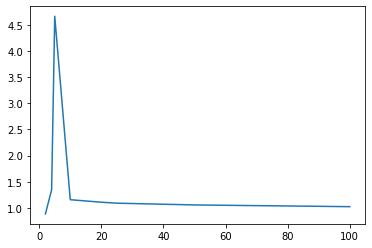

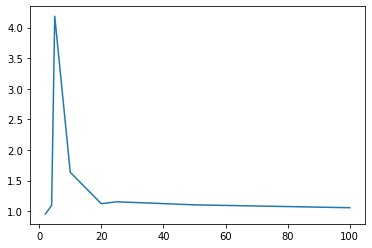

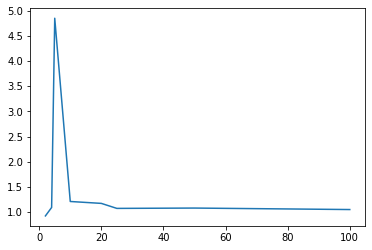

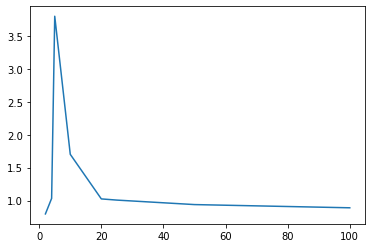

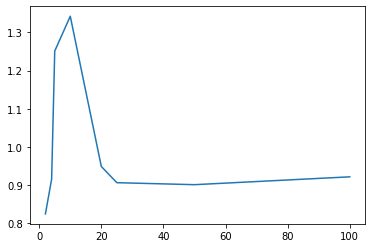

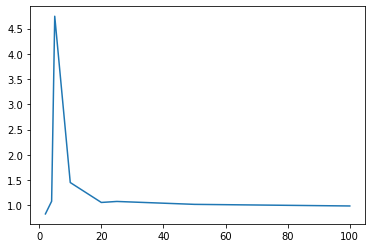

In [10]:
n = 100; p = 5
plt.ylim(0.3, 1.5)
plt.xlabel('k')
plt.ylabel('loss')
for j in range(2, 11, 1):
  X = randn(n, p)
  X = np.insert(X, 0, 1, axis=1)
  beta = randn(p+1)
  y = X@beta + randn(n)
  U = []; V = []
  for k in range(2, n+1, 1):
    if n%k == 0:
      loss = cv_fast(X, y, k)
      U.append(k); V.append(loss)
  plt.plot(U, V)
  plt.show()

## 10-fold for iris dataset

In [0]:
from sklearn.datasets import load_iris

In [0]:
def knn_1(x, y, z, k):
  """ knn for one target data
  """
  x = np.array(x); y = np.array(y)
  dis = []
  for i in range(x.shape[0]):
    dis.append(np.linalg.norm(z - x[i, ], ord=2))
  S = np.argsort(dis)[0:k]
  #print(S)
  #print(dis[S[0]], dis[S[1]], dis[S[2]])
  u = np.bincount(y[S])
  #print(y[S])
  #print(u)
  m = [i for i, x in enumerate(u) if x==max(u)]
  #print(m)
  while (len(m)>1):
    k = k-1
    S = S[0:k]
    u = np.bincount(y[S])
    m = [i for i, x in enumerate(u) if x==max(u)]
  return m[0]

In [0]:
def knn(x, y, z, k):
  w = []
  for i in range(z.shape[0]):
    w.append(knn_1(x, y, z[i, ], k))
  return w

In [0]:
iris = load_iris()
iris.target_names
x = iris.data
y = iris.target
n = x.shape[0]
order = np.random.choice(n, n, replace=False)
x = x[order, ]
y = y[order]

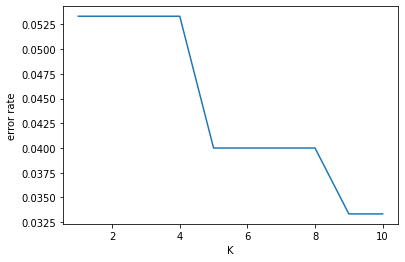

In [22]:
U = []; V = []
top_seq = list(range(0, 135, 10))
for k in range(1, 11, 1):
  S = 0
  for top in top_seq:
    test = list(range(top, top+15))
    train = list(set(range(150)) - set(test))
    knn_ans = knn(x[train, ], y[train], x[test, ], k=k)
    ans = y[test]
    S += np.sum(knn_ans!=ans)
  S /= n
  U.append(k); V.append(S)
plt.xlabel('K')
plt.ylabel('error rate')
plt.plot(U, V)
plt.show()

## boostrap

In [0]:
def bt(df, f, r):
  m = df.shape[0]
  org = f(df, np.arange(0, m, 1))
  u = []
  for j in range(r):
    index = np.random.choice(m, m, replace=True)
    u.append(f(df, index))
  return {'original': org, 'bias': np.mean(u)-org, 'stderr': np.std(u)}

In [0]:
from sklearn import linear_model

In [29]:
!wget http://web.stanford.edu/~hastie/StatLearnSparsity_files/DATA/crime.txt

--2020-06-08 01:29:29--  http://web.stanford.edu/~hastie/StatLearnSparsity_files/DATA/crime.txt
Resolving web.stanford.edu (web.stanford.edu)... 171.67.215.200
Connecting to web.stanford.edu (web.stanford.edu)|171.67.215.200|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1143 (1.1K) [text/plain]
Saving to: ‘crime.txt’

crime.txt           100%[===================>]   1.12K  --.-KB/s    in 0s      

2020-06-08 01:29:29 (145 MB/s) - ‘crime.txt’ saved [1143/1143]



In [0]:
df = np.loadtxt('crime.txt', delimiter='\t')

In [31]:
reg = linear_model.LinearRegression()
X = df[:, [2, 3]]
y = df[:, 0]
reg.fit(X, y)
reg.coef_

array([11.8583308 , -5.97341169])

In [37]:
for j in range(3):
  def func_2(data, index):
    X = data[index, 2:4]; y = data[index, 0]
    reg.fit(X, y)
    if j == 0:
      return reg.intercept_
    else:
      return reg.coef_
  print(bt(df, func_2, 1000))

{'original': 621.4260363802889, 'bias': 30.701791200024445, 'stderr': 220.13947230073416}
{'original': array([11.8583308 , -5.97341169]), 'bias': array([-9.32968774,  8.50205475]), 'stderr': 9.301466685340493}
{'original': array([11.8583308 , -5.97341169]), 'bias': array([-9.36953912,  8.46220337]), 'stderr': 9.402285821356474}


In [38]:
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [39]:
n = X.shape[0]
X = np.insert(X, 0, 1, axis=1)
model = sm.OLS(y, X)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     11.30
Date:                Mon, 08 Jun 2020   Prob (F-statistic):           9.84e-05
Time:                        01:39:21   Log-Likelihood:                -344.79
No. Observations:                  50   AIC:                             695.6
Df Residuals:                      47   BIC:                             701.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        621.4260    222.685      2.791      0.0